# Anomaly detection to spot irregular/high frequent transaction on Eniara Wallet to Wallet transactions. 
- AML Usecase I
- Appoach: Using unsupervised learning algorithm with Isolation Forest.

In [1]:
import pandas as pd 
import seaborn as sns
import cx_Oracle
import datetime  
import matplotlib.pyplot as plt
import os  
import re  
import numpy as np
import pandas as pd
import warnings  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('precision', 0)

warnings.filterwarnings('ignore')

#Mail Libraries
import requests
from bs4 import BeautifulSoup
import csv
import os
import io
import re
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email.message import EmailMessage
from email import encoders

import pickle
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
anomaly_proportion = 0.008

from category_encoders import *

#### Data ingestion

In [4]:
try:
    dsn_tns = cx_Oracle.makedsn(host='172.16.7.35',port='1521', sid='centradb')
    cnxn = cx_Oracle.connect(user=r'dwuser', password='dwuser', dsn=dsn_tns)
    cursor = cnxn.cursor()
    mySql_select_Query = """select a.*,b.phone,b.bvn,b.result,b.date_of_birth,b.state,b.tax_identification_number,b.country_of_birth,b.state,b.watchlisted,b.nin from (
                                                select 
                                                a.id,
                                                a.tenant_key,
                                                to_date(a.inserted_at, 'DD-MM-YY HH24:MI:SS') as inserted_at,
                                                a.updated_at,
                                                a.guid,
                                                a.amount_with_currency,
                                                a.source_wallet_guid,
                                                a.destination_wallet_guid,
                                                a.merchant_label,
                                                a.current_state,
                                                a.note,
                                                a.payment_detail_guid,
                                                b.guid as guid_wh ,
                                                b.email,
                                                b.kyc_status,
                                                b.alias,
                                                b.tier_level 
                                                from enaira.COMMERCE_PAYMENTS a
                                                left join enaira.COMMERCE_WALLET_HOLDERS b
                                                on a.source_wallet_guid = b.guid  WHERE LENGTH (a.INSERTED_AT)=14) a
                                                left join enaira.kycpersonal b
                                                on a.email = b.email_id and
                                                   a.alias = b.wallet_alias"""
    result = cursor.execute(mySql_select_Query)
    queryFetch = cursor.fetchall()
    queryResults = pd.DataFrame.from_records(queryFetch, columns = [i[0] for i in cursor.description])
    print('Working ')
except cx_Oracle.DatabaseError as error:
    #print(error)
    print("Failed to connect: You go need check am".format(error))

Working 


In [118]:
df=queryResults.copy()

In [119]:
#df=pd.read_csv('commerce_payment_with_tiers_new_01.csv')

In [120]:
df.shape

(618700, 27)

In [121]:
df.head(100)

,ID,TENANT_KEY,INSERTED_AT,UPDATED_AT,GUID,AMOUNT_WITH_CURRENCY,SOURCE_WALLET_GUID,DESTINATION_WALLET_GUID,MERCHANT_LABEL,CURRENT_STATE,NOTE,PAYMENT_DETAIL_GUID,GUID_WH,EMAIL,KYC_STATUS,ALIAS,TIER_LEVEL,PHONE,BVN,RESULT,DATE_OF_BIRTH,STATE,TAX_IDENTIFICATION_NUMBER,COUNTRY_OF_BIRTH,STATE,WATCHLISTED,NIN
0,1,gtb,2021-10-06 12:58:00,06/10/21 12:58,017c55ae-f3d7-f262-2666-8e2a0ea75c46,"(50000,ENGN)",017c54ef-0069-e597-9697-1f4118674491,017c4b6f-e9e1-3090-5721-e6bd133e6ce1,None,complete,None,017c55ae-f3e5-1721-eebd-5921fd911ec4,017c54ef-0069-e597-9697-1f4118674491,adnubah@yahoo.com,ACCEPTED,@ababajo.01,2,07066006613,22147804376,ACCEPTED,1987-02-11,None,None,None,None,None,None
1,2,gtb,2021-10-06 13:09:00,06/10/21 13:09,017c55b8-ea16-aabf-8609-5532b1527eb9,"(5000,ENGN)",017c54ef-335f-ad15-3b76-f141c7da3aca,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,None,complete,None,017c55b8-ea22-0771-74dc-2e1bc729df49,017c54ef-335f-ad15-3b76-f141c7da3aca,abumaresq@gmail.com,ACCEPTED,@aumar.01,2,08035936232,22141812795,ACCEPTED,1963-07-10,None,None,None,None,None,None
2,3,gtb,2021-10-06 13:09:00,06/10/21 13:10,017c55b9-63ea-dbca-6a39-a27f8d82bc9a,"(5000,ENGN)",017c54ef-335f-ad15-3b76-f141c7da3aca,017c5103-a88a-e25e-49dc-d8d765f87057,None,complete,None,017c55b9-63f7-82bf-a8cd-6a46bb3ffcf9,017c54ef-335f-ad15-3b76-f141c7da3aca,abumaresq@gmail.com,ACCEPTED,@aumar.01,2,08035936232,22141812795,ACCEPTED,1963-07-10,None,None,None,None,None,None
3,4,gtb,2021-10-06 13:31:00,06/10/21 13:32,017c55cd-a180-36df-461f-b4468e3bacb6,"(2000,ENGN)",017c4c88-abe0-ba63-9551-94a5a424f5fa,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,None,complete,None,017c55cd-a18b-91b4-ad52-ced9b2094d00,017c4c88-abe0-ba63-9551-94a5a424f5fa,rsmlive@gmail.com,ACCEPTED,@rmohamm.01,2,08033889414,22142842973,ACCEPTED,1966-01-11,None,None,None,None,None,None
4,5,gtb,2021-10-06 13:32:00,06/10/21 13:32,017c55ce-66d6-e0b5-6134-d9010cd54f79,"(1000,ENGN)",017c4c88-abe0-ba63-9551-94a5a424f5fa,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,None,complete,None,017c55ce-66df-05bd-27d1-a697c347fae2,017c4c88-abe0-ba63-9551-94a5a424f5fa,rsmlive@gmail.com,ACCEPTED,@rmohamm.01,2,08033889414,22142842973,ACCEPTED,1966-01-11,None,None,None,None,None,None
5,6,sterling,2021-10-06 13:38:00,06/10/21 13:38,017c55d3-6179-a8b4-626d-66fb1d2032aa,"(1000,ENGN)",017c5103-a88a-e25e-49dc-d8d765f87057,017c54ef-335f-ad15-3b76-f141c7da3aca,None,complete,None,017c55d3-6181-d3a1-8d7f-9f4d317fac1f,017c5103-a88a-e25e-49dc-d8d765f87057,vesselofthelord07@yahoo.co.uk,ACCEPTED,@eetim.01,2,08076033676,22148009266,ACCEPTED,1985-07-14,None,None,None,None,None,None
6,7,gtb,2021-10-06 13:40:00,06/10/21 13:40,017c55d5-150b-06eb-45b4-2c0a56541837,"(1000,ENGN)",017c4c88-abe0-ba63-9551-94a5a424f5fa,017c4adc-18b3-22cb-8f65-8bd011fbf8ba,None,complete,None,017c55d5-1515-f54a-1f49-37947585fcfe,017c4c88-abe0-ba63-9551-94a5a424f5fa,rsmlive@gmail.com,ACCEPTED,@rmohamm.01,2,08033889414,22142842973,ACCEPTED,1966-01-11,None,None,None,None,None,None
7,8,gtb,2021-10-06 13:42:00,06/10/21 13:42,017c55d6-fa47-d214-662c-25dc1d2da55d,"(20000,ENGN)",017c4c88-abe0-ba63-9551-94a5a424f5fa,017c55c0-b330-f7cf-e8bd-b9f286afd765,None,complete,None,017c55d6-fa51-6431-5736-efa0201a879a,017c4c88-abe0-ba63-9551-94a5a424f5fa,rsmlive@gmail.com,ACCEPTED,@rmohamm.01,2,08033889414,22142842973,ACCEPTED,1966-01-11,None,None,None,None,None,None
8,9,sterling,2021-10-06 13:42:00,06/10/21 13:42,017c55d7-17d4-87c0-f5ba-1ad7fd8bc1fe,"(500,ENGN)",017c4adc-18b3-22cb-8f65-8bd011fbf8ba,017c55c0-b330-f7cf-e8bd-b9f286afd765,None,complete,None,017c55d7-17e0-e293-2f0a-6ca60c1f5c12,017c4adc-18b3-22cb-8f65-8bd011fbf8ba,oseikhis@gmail.com,ACCEPTED,@oikhidu.01,2,08033934120,22210643057,ACCEPTED,1986-12-27,None,None,None,None,None,None
9,10,gtb,2021-10-06 13:46:00,06/10/21 13:46,017c55da-9544-daf0-035b-5517e2a9935a,"(5000,ENGN)",017c51ac-eb4b-4afc-bdf8-22ef40684524,017c54ef-335f-ad15-3b76-f141c7da3aca,None,complete,None,017c55da-954f-3518-dd0a-8a9679b27385,017c51ac-eb4b-4afc-bdf8-22ef40684524,musaitopa@yahoo.com,ACCEPTE

In [122]:
df.INSERTED_AT.max(),df.INSERTED_AT.min()

(Timestamp('2022-12-07 08:29:00'), Timestamp('2021-10-06 12:58:00'))

In [123]:
df.isnull().sum()

ID                                0
TENANT_KEY                        0
INSERTED_AT                       0
UPDATED_AT                        0
GUID                              0
AMOUNT_WITH_CURRENCY              0
SOURCE_WALLET_GUID                0
DESTINATION_WALLET_GUID           0
MERCHANT_LABEL               301516
CURRENT_STATE                     0
NOTE                         493358
PAYMENT_DETAIL_GUID               0
GUID_WH                      403039
EMAIL                        403039
KYC_STATUS                   403039
ALIAS                        403039
TIER_LEVEL                   403039
PHONE                        410863
BVN                          411009
RESULT                       410863
DATE_OF_BIRTH                411005
STATE                        507444
TAX_IDENTIFICATION_NUMBER    618499
COUNTRY_OF_BIRTH             508119
STATE                        507444
WATCHLISTED                  509311
NIN                          616189
dtype: int64

In [124]:
df.COUNTRY_OF_BIRTH.value_counts()

NG    110581
Name: COUNTRY_OF_BIRTH, dtype: int64

#### Data Precocessing

In [125]:
### Data cleaning and preprocessing
def data_cleaning(df):
    df['AMOUNT_Cleaned'] = df['AMOUNT_WITH_CURRENCY'].str.extract('([0-9]+)', expand=False) ## clean amount column
    df['INSERTED_AT'] = pd.to_datetime(df["INSERTED_AT"])
    df['date'] = df['INSERTED_AT'].dt.date 
    df['day'] = df['INSERTED_AT'].dt.day ## Extract day,time, hour of the day
    df['month'] = df['INSERTED_AT'].dt.month
    df['time'] = df['INSERTED_AT'].dt.time
    df['hour'] = df['INSERTED_AT'].dt.hour
    df['minute'] = df['INSERTED_AT'].dt.minute
    df['second'] = df['INSERTED_AT'].dt.second
    df["AMOUNT_Cleaned"] = df["AMOUNT_Cleaned"].astype(int)
    df['TIER_LEVEL'] = df['TIER_LEVEL'].astype('str')
    df['TIER_LEVEL'] = [x.split('.')[-0] for x in df['TIER_LEVEL']] ## covert tier level to string
    df.TIER_LEVEL = df.TIER_LEVEL.replace('nan', 'missing')
    df["TIER_LEVEL"] = df["TIER_LEVEL"].astype(str)
    return df

In [126]:
data=data_cleaning(df)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618700 entries, 0 to 618699
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         618700 non-null  object        
 1   TENANT_KEY                 618700 non-null  object        
 2   INSERTED_AT                618700 non-null  datetime64[ns]
 3   UPDATED_AT                 618700 non-null  object        
 4   GUID                       618700 non-null  object        
 5   AMOUNT_WITH_CURRENCY       618700 non-null  object        
 6   SOURCE_WALLET_GUID         618700 non-null  object        
 7   DESTINATION_WALLET_GUID    618700 non-null  object        
 8   MERCHANT_LABEL             317184 non-null  object        
 9   CURRENT_STATE              618700 non-null  object        
 10  NOTE                       125342 non-null  object        
 11  PAYMENT_DETAIL_GUID        618700 non-null  object  

#### We considered removing transactions from CBNFI (tenant key), considering this are transaction coming directly from the bank

In [86]:
df_n=df[df['TENANT_KEY']=='cbnfi']

In [87]:
df_n.shape

(246960, 35)

In [109]:
#df_n.SOURCE_WALLET_GUID.value_counts()

In [89]:
df.columns

Index(['ID', 'TENANT_KEY', 'INSERTED_AT', 'UPDATED_AT', 'GUID',
       'AMOUNT_WITH_CURRENCY', 'SOURCE_WALLET_GUID', 'DESTINATION_WALLET_GUID',
       'MERCHANT_LABEL', 'CURRENT_STATE', 'NOTE', 'PAYMENT_DETAIL_GUID',
       'GUID_WH', 'EMAIL', 'KYC_STATUS', 'ALIAS', 'TIER_LEVEL', 'PHONE', 'BVN',
       'RESULT', 'DATE_OF_BIRTH', 'STATE', 'TAX_IDENTIFICATION_NUMBER',
       'COUNTRY_OF_BIRTH', 'STATE', 'WATCHLISTED', 'NIN', 'AMOUNT_Cleaned',
       'date', 'day', 'month', 'time', 'hour', 'minute', 'second'],
      dtype='object')

In [127]:
def clean_missing_values(df):
    df=df[df['TENANT_KEY']!='cbnfi']  ## remove cbnfi
    df.MERCHANT_LABEL.fillna('missing',inplace=True)  ## fill na's with missing
    df.KYC_STATUS.fillna('UNKNOWN',inplace=True) ## fill na's with Unknown
    df['EMAIL']=df['EMAIL'].str.lower() ## extract mail group
    df['domain'] = df['EMAIL'].str.split('@').str[1]
    df['domain']=df['domain'].astype(str)
    df = df.replace(['nan'],'noemail.com')
    df['MailGroup'] = pd.np.where(df.domain.str.contains("None|noemail.com|nomail.com|non.com|no.com"),"No-Email",
                      pd.np.where(df.domain.str.contains("gmail.com|gmail.com|yahoo.com|yahoo.co.uk|hotmail.com|\
                                                      outlook.com|rocketmail.com|hotmail.co.uk|yahoo.com.au|\
                                                      aol.com|hotmail.co.uk|hotmail.fr|\
                                                      msn.com|yahoo.fr|wanadoo.fr|orange.fr|comcast.net|yahoo.co.uk|\
                                                      yahoo.com.br|yahoo.co.in|live.com|rediffmail.com|free.fr|gmx.de|\
                                                      web.de|yandex.ru|ymail.com|libero.it|outlook.com|uol.com.br|\
                                                      bol.com.br|mail.ru|cox.net|hotmail.it|sbcglobal.net|sfr.fr|live.fr|\
                                                      verizon.net|live.co.uk|googlemail.com|yahoo.es|live.nl|bigpond.com|\
                                                      terra.com.br|yahoo.it|neuf.fr|yahoo.de|alice.it|rocketmail.com|att.net|\
                                                      laposte.net|facebook.com|bellsouth.net|yahoo.in|hotmail.es|harter.net|\
                                                      yahoo.ca|yahoo.com.au|rambler.ru|hotmail.de|shaw.ca|yahoo.co.jp|sky.com|\
                                                      earthlink.net|optonline.net|freenet.de|t-online.de|aliceadsl.fr|virgilio.it|\
                                                      home.nl|qq.com|telenet.be|me.com|yahoo.com.ar|tiscali.co.uk|yahoo.com.mx|\
                                                      voila.fr|gmx.net|mail.com|planet.nl|tin.it|live.it|ntlworld.com|arcor.de|\
                                                      yahoo.co.id|frontiernet.net|hetnet.nl|live.com.au|yahoo.com.sg|zonnet.nl|\
                                                      club-internet.fr|juno.com|optusnet.com.au|blueyonder.co.uk|bluewin.ch|\
                                                      skynet.be|sympatico.ca|windstream.net|mac.com|centurytel.net|chello.nl|\
                                                      live.ca|aim.com|bigpond.net.au"                                             
                                                      ,regex=True), "Personal-Email","ProfessionalEmail"
                  ))
    df.drop(['domain'],inplace=True,axis=1)
    df['BVN'] = df['BVN'].astype('str')
    df['bvn_flag'] = np.where((df['BVN'] !='None'), 'yes', 'no')
    return df

In [130]:
df.KYC_STATUS.isnull().sum()

156088

In [129]:
df=clean_missing_values(data)

In [131]:
df.columns

Index(['ID', 'TENANT_KEY', 'INSERTED_AT', 'UPDATED_AT', 'GUID',
       'AMOUNT_WITH_CURRENCY', 'SOURCE_WALLET_GUID', 'DESTINATION_WALLET_GUID',
       'MERCHANT_LABEL', 'CURRENT_STATE', 'NOTE', 'PAYMENT_DETAIL_GUID',
       'GUID_WH', 'EMAIL', 'KYC_STATUS', 'ALIAS', 'TIER_LEVEL', 'PHONE', 'BVN',
       'RESULT', 'DATE_OF_BIRTH', 'STATE', 'TAX_IDENTIFICATION_NUMBER',
       'COUNTRY_OF_BIRTH', 'STATE', 'WATCHLISTED', 'NIN', 'AMOUNT_Cleaned',
       'date', 'day', 'month', 'time', 'hour', 'minute', 'second', 'MailGroup',
       'bvn_flag'],
      dtype='object')

### Data Transformation

In [132]:
## aggregate dataframe by minute and select columns 
def transform_data(df):
    count_trans_hm = df.groupby(by = ['SOURCE_WALLET_GUID','TIER_LEVEL','MERCHANT_LABEL','CURRENT_STATE','date','MailGroup','bvn_flag','KYC_STATUS','month','day','hour','minute']).agg(count_trans=('SOURCE_WALLET_GUID', 'count'),Total_transacted_perminute=("AMOUNT_Cleaned",'sum')).reset_index(drop=False)
    count_trans_hm.columns = ['SOURCE_WALLET_GUID','TIER_LEVEL','MERCHANT_LABEL','CURRENT_STATE','date','MailGroup','bvn_flag','KYC_STATUS','month','day','hour','minute','count_trans','Total_transacted_perminute']
    count_trans_hm=count_trans_hm.sort_values(by='SOURCE_WALLET_GUID',ascending=True)
    return count_trans_hm

In [133]:
count_trans_hm=transform_data(df)

In [134]:
count_trans_hm.head(10)

,SOURCE_WALLET_GUID,TIER_LEVEL,MERCHANT_LABEL,CURRENT_STATE,date,MailGroup,bvn_flag,KYC_STATUS,month,day,hour,minute,count_trans,Total_transacted_perminute
0,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-05-31,Personal-Email,yes,ACCEPTED,5,31,10,4,1,150000
22,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-12-05,Personal-Email,yes,ACCEPTED,12,5,17,18,1,400000
21,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-12-05,Personal-Email,yes,ACCEPTED,12,5,7,32,1,2000000
20,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-12-04,Personal-Email,yes,ACCEPTED,12,4,20,1,1,1000000
18,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-11-17,Personal-Email,yes,ACCEPTED,11,17,14,18,1,58000
17,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-10-27,Personal-Email,yes,ACCEPTED,10,27,20,57,1,20000
16,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-10-25,Personal-Email,yes,ACCEPTED,10,25,21,41,1,140000
15,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-10-18,Personal-Email,yes,ACCEPTED,10,18,13,32,1,12000
14,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-10-16,Personal-Email,yes,ACCEPTED,10,16,14,57,1,20000
13,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-10-09,Personal-Email,yes,ACCEPTED,10,9,20,45,1,20000


In [97]:
count_trans_hm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153953 entries, 0 to 153952
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SOURCE_WALLET_GUID          153953 non-null  object 
 1   TIER_LEVEL                  153953 non-null  object 
 2   MERCHANT_LABEL              153953 non-null  object 
 3   CURRENT_STATE               153953 non-null  object 
 4   date                        153953 non-null  object 
 5   MailGroup                   153953 non-null  object 
 6   bvn_flag                    153953 non-null  object 
 7   KYC_STATUS                  153953 non-null  object 
 8   month                       153953 non-null  int64  
 9   day                         153953 non-null  int64  
 10  hour                        153953 non-null  int64  
 11  minute                      153953 non-null  int64  
 12  count_trans                 153953 non-null  int64  
 13  Total_transact

In [98]:
count_trans_hm["date"] = pd.to_datetime(count_trans_hm["date"])

In [112]:
validation_data = count_trans_hm[(count_trans_hm['date'] >= '2022-10-01') & (count_trans_hm['date'] <= '2022-11-30')]

In [115]:
validation_data[(validation_data['Fraud_Flag'] == 'Fraudulent') & (validation_data['count_trans'] > 1)].head(100)

,SOURCE_WALLET_GUID,TIER_LEVEL,MERCHANT_LABEL,CURRENT_STATE,date,MailGroup,bvn_flag,KYC_STATUS,month,day,hour,minute,count_trans,Total_transacted_perminute,merchant_label_,tier_level_,current_state_,MailGroup_,bvn_flag_,kyc_status_,y_pred,y_scores,Fraud_Flag
46620,018118f4-6743-50d6-ddcb-fdbf46092a86,2,ecommerce,complete,2022-10-16,ProfessionalEmail,no,ACCEPTED,10,16,8,16,2,1000000,1,1,1,2,2,1,1,0.014,Fraudulent
149521,0184245d-eb95-7497-61a1-b1b13731f19a,2,ecommerce,complete,2022-11-10,ProfessionalEmail,no,ACCEPTED,11,10,9,59,2,400000,1,1,1,2,2,1,1,0.049,Fraudulent
149818,01842539-cfd8-f427-3d69-d4c363c005f3,2,ecommerce,complete,2022-11-06,Personal-Email,no,ACCEPTED,11,6,11,57,2,4000,1,1,1,1,2,1,1,0.013,Fraudulent
149863,01842598-3b3c-c165-79b3-bb2d447552ab,2,ecommerce,complete,2022-10-30,Personal-Email,no,ACCEPTED,10,30,0,42,2,10000000,1,1,1,1,2,1,1,0.030,Fraudulent
149865,0184259d-e3de-b2c4-0d8c-78933d6c38d0,2,ecommerce,complete,2022-10-30,Personal-Email,no,ACCEPTED,10,30,1,10,2,10000000,1,1,1,1,2,1,1,0.027,Fraudulent
149868,0184259d-e3de-b2c4-0d8c-78933d6c38d0,2,ecommerce,complete,2022-11-02,Personal-Email,no,ACCEPTED,11,2,14,52,2,4000000,1,1,1,1,2,1,1,0.019,Fraudulent
150660,0184333a-14dc-9734-367e-3c2ca5b35e11,2,ecommerce,complete,2022-11-02,Personal-Email,no,ACCEPTED,11,2,15,13,2,40000,1,1,1,1,2,1,1,0.019,Fraudulent
150907,01843dea-7e95-1503-7f15-0c423c192b9f,2,ecommerce,complete,2022-11-03,Personal-Email,no,ACCEPTED,11,3,18,32,2,2445000,1,1,1,1,2,1,1,0.022,Fraudulent
150892,01843dea-7e95-1503-7f15-0c423c192b9f,2,ecommerce,complete,2022-11-03,Personal-Email,no,ACCEPTED,11,3,15,16,2,2315000,1,1,1,1,2,1,1,0.020,Fraudulent
151081,018441c4-9a4e-26e9-cad7-1e7154118796,2,ecommerce,complete,2022-11-04,Personal-Email,no,ACCEPTED,11,4,22,7,2,5000,1,1,1,1,2,1,1,0.025,Fraudulent


In [116]:
validation_data.to_csv('Freq_val_data_new.csv',index=False)

In [156]:
validation_data.columns

Index(['SOURCE_WALLET_GUID', 'TIER_LEVEL', 'MERCHANT_LABEL', 'CURRENT_STATE',
       'date', 'MailGroup', 'bvn_flag', 'KYC_STATUS', 'month', 'day', 'hour',
       'minute', 'count_trans', 'Total_transacted_perminute',
       'merchant_label_', 'tier_level_', 'current_state_', 'MailGroup_',
       'bvn_flag_', 'kyc_status_', 'y_pred', 'y_scores', 'Fraud_Flag'],
      dtype='object')

## EDA

### Check corrrelations 

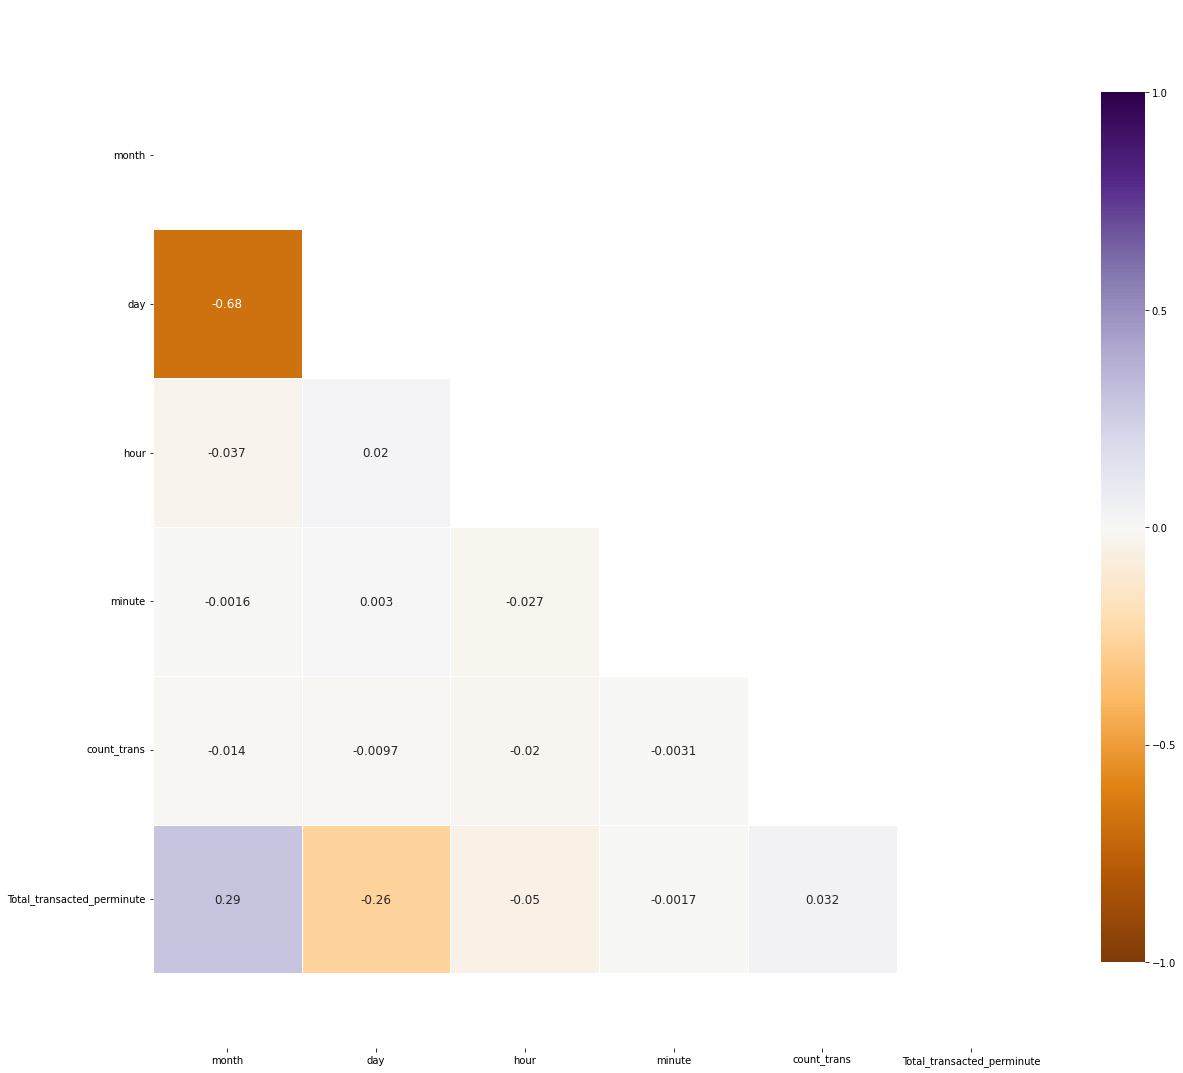

In [29]:
corr_matrix=count_trans_hm.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
f, ax = plt.subplots(figsize=(20, 40))
heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'PuOr',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.savefig('cmmatrix1.png')
plt.show() # ta-da!


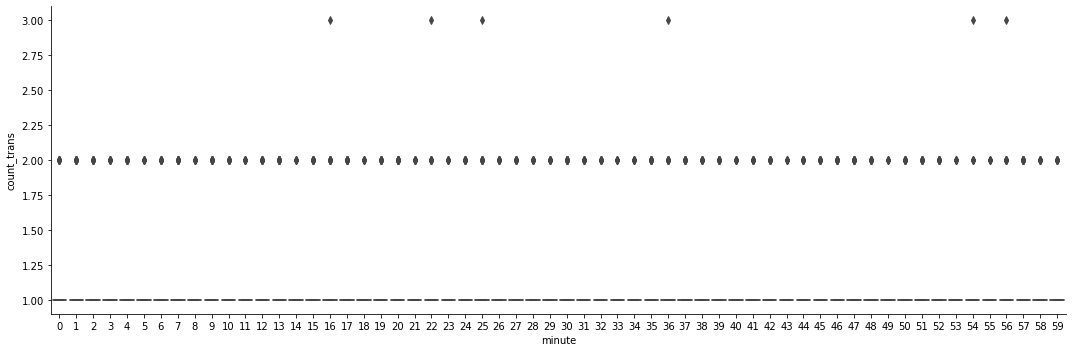

In [30]:
import seaborn as sns
sns.catplot(x="minute", y="count_trans",
            kind="box", data=count_trans_hm,
            aspect=3.0)

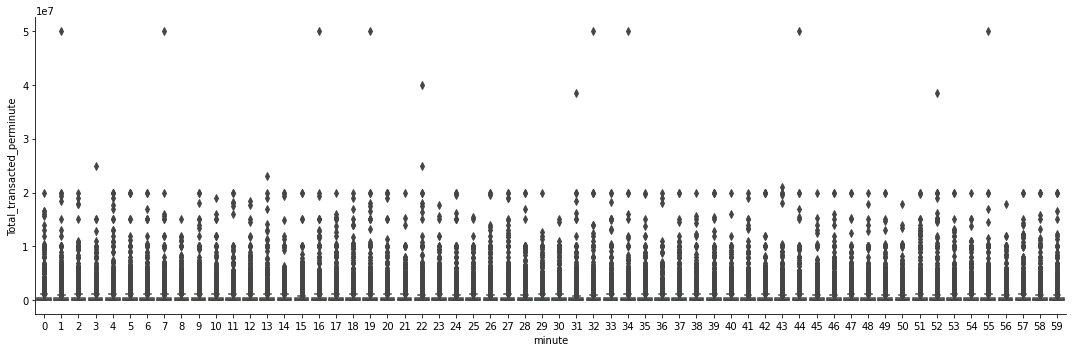

In [31]:
sns.catplot(x="minute", y="Total_transacted_perminute",
            kind="box", data=count_trans_hm,
            aspect=3.0)

## Model Building

Variables selected for modeling
- tier_level: tier level of transaction
- merchant_label: merchant label
- current_state: current state
- MailGroup: Email group, professional, personal or no email
- BVN Flag: Wether customer has bvn imformation or not
- KYC status: Know your customer information

In [135]:
def detect_outliers(count_trans_hm):
    count_trans_hm[['merchant_label_','tier_level_','current_state_','MailGroup_','bvn_flag_','kyc_status_']]=count_trans_hm[['TIER_LEVEL','MERCHANT_LABEL','CURRENT_STATE','MailGroup','bvn_flag','KYC_STATUS']]
    categ = ['tier_level_','merchant_label_','current_state_','MailGroup_','bvn_flag_','kyc_status_']

    # Encode Categorical Columns
    enc = OrdinalEncoder().fit(count_trans_hm[categ])
    count_trans_hm[categ]= enc.transform(count_trans_hm[categ])

    filehandler = open("enc_v1_freq_dec.obj","wb")
    pickle.dump(enc,filehandler)
    filehandler.close()

    file = open("enc_v1_freq_dec.obj",'rb')
    enc_loaded = pickle.load(file)
    file.close()

    # train IForest detector
    clf_name = 'Anomaly Detection - Isolation Forest'
    clf = IForest(contamination=anomaly_proportion)

    X = count_trans_hm[['tier_level_','count_trans','merchant_label_','current_state_','MailGroup_','kyc_status_','bvn_flag_','day','month','hour','minute']]
    clf.fit(X)

    # get the prediction labels and outlier scores of the training data
    count_trans_hm['y_pred'] = clf.labels_ # binary labels (0: inliers, 1: outliers)
    count_trans_hm['y_scores'] = clf.decision_scores_ # raw outlier scores. The bigger the number the greater the anomaly.
    fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': X.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', title='Feature Importance',figsize=(10, 10))
    return count_trans_hm,_

## Model output and feature importance

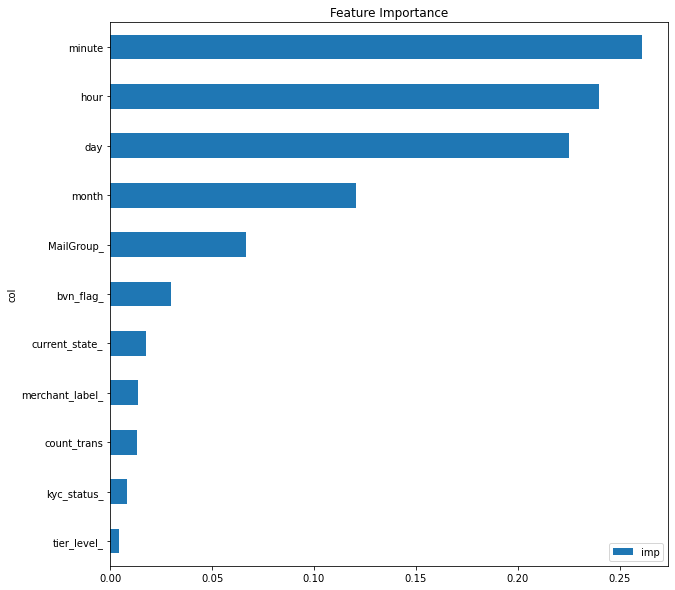

In [136]:
count_trans_hm,_=detect_outliers(count_trans_hm)

In [137]:
count_trans_hm.head()

,SOURCE_WALLET_GUID,TIER_LEVEL,MERCHANT_LABEL,CURRENT_STATE,date,MailGroup,bvn_flag,KYC_STATUS,month,day,hour,minute,count_trans,Total_transacted_perminute,merchant_label_,tier_level_,current_state_,MailGroup_,bvn_flag_,kyc_status_,y_pred,y_scores
0,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-05-31,Personal-Email,yes,ACCEPTED,5,31,10,4,1,150000,1,1,1,1,1,1,0,-0.112
22,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-12-05,Personal-Email,yes,ACCEPTED,12,5,17,18,1,400000,1,1,1,1,1,1,0,-0.178
21,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-12-05,Personal-Email,yes,ACCEPTED,12,5,7,32,1,2000000,1,1,1,1,1,1,0,-0.181
20,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-12-04,Personal-Email,yes,ACCEPTED,12,4,20,1,1,1000000,1,1,1,1,1,1,0,-0.107
18,017c49b0-ea5a-de1d-9e0d-c90a63b28e6f,2,ecommerce,complete,2022-11-17,Personal-Email,yes,ACCEPTED,11,17,14,18,1,58000,1,1,1,1,1,1,0,-0.240


In [138]:
count_trans_hm.count_trans.max()

3

### Rename predictions into fraudulent and non fraudulent transactions

In [139]:
def create_flag(df):
    doc={0:'Non_Fraudulent',1:'Fraudulent'}
    dataset=[df]
    for data in dataset:
        df['Fraud_Flag']=df['y_pred'].replace(doc)
    return df

In [140]:
data=create_flag(count_trans_hm)

In [141]:
data.Fraud_Flag.value_counts()

Non_Fraudulent    152721
Fraudulent          1232
Name: Fraud_Flag, dtype: int64

## Validation of model predictions

In [142]:
data[(data['Fraud_Flag'] == 'Fraudulent') & (data['CURRENT_STATE'] == 'failed')].head(10)

,SOURCE_WALLET_GUID,TIER_LEVEL,MERCHANT_LABEL,CURRENT_STATE,date,MailGroup,bvn_flag,KYC_STATUS,month,day,hour,minute,count_trans,Total_transacted_perminute,merchant_label_,tier_level_,current_state_,MailGroup_,bvn_flag_,kyc_status_,y_pred,y_scores,Fraud_Flag
1028,017c702b-7817-8dde-d0d1-45254d8fdb48,2,ecommerce,failed,2022-12-04,ProfessionalEmail,yes,ACCEPTED,12,4,6,43,1,90000,1,1,3,2,1,1,1,0.007,Fraudulent
6670,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-22,Personal-Email,yes,DENIED,9,22,21,33,2,240000,1,1,3,1,1,2,1,0.043,Fraudulent
6665,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-22,Personal-Email,yes,DENIED,9,22,21,18,2,240000,1,1,3,1,1,2,1,0.040,Fraudulent
6664,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-22,Personal-Email,yes,DENIED,9,22,21,17,2,240000,1,1,3,1,1,2,1,0.040,Fraudulent
6690,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-23,Personal-Email,yes,DENIED,9,23,1,49,2,240000,1,1,3,1,1,2,1,0.049,Fraudulent
6679,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-22,Personal-Email,yes,DENIED,9,22,22,7,2,240000,1,1,3,1,1,2,1,0.042,Fraudulent
6680,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-22,Personal-Email,yes,DENIED,9,22,22,9,2,240000,1,1,3,1,1,2,1,0.043,Fraudulent
6682,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-22,Personal-Email,yes,DENIED,9,22,22,11,2,240000,1,1,3,1,1,2,1,0.038,Fraudulent
6685,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-23,Personal-Email,yes,DENIED,9,23,1,44,2,240000,1,1,3,1,1,2,1,0.057,Fraudulent
6686,017ccb91-6fdd-ffcc-0fa8-b845c106e16b,2,ecommerce,failed,2022-09-23,Personal-Email,yes,DENIED,9,23,1,45,2,240000,1,1,3,1,1,2,1,0.055,Fraudulent


In [45]:
data[(data['TIER_LEVEL'] == 'missing') & (data['CURRENT_STATE'] == 'failed')].head(10)

,SOURCE_WALLET_GUID,TIER_LEVEL,MERCHANT_LABEL,CURRENT_STATE,date,MailGroup,bvn_flag,KYC_STATUS,month,day,hour,minute,count_trans,Total_transacted_perminute,merchant_label_,tier_level_,current_state_,MailGroup_,bvn_flag_,kyc_status_,y_pred,y_scores,Fraud_Flag


In [29]:
data.columns

Index(['source_wallet_guid', 'tier_level', 'merchant_label', 'current_state',
       'date', 'MailGroup', 'bvn_flag', 'kyc_status', 'month', 'day', 'hour',
       'minute', 'count_trans', 'Total_transacted_perminute',
       'merchant_label_', 'tier_level_', 'current_state_', 'MailGroup_',
       'bvn_flag_', 'kyc_status_', 'y_pred', 'y_scores', 'Fraud_Flag'],
      dtype='object')

In [30]:
dat=data[['source_wallet_guid', 'tier_level', 'merchant_label', 'current_state',
       'date', 'MailGroup', 'bvn_flag', 'kyc_status', 'month', 'day', 'hour',
       'minute', 'count_trans', 'Total_transacted_perminute', 'y_pred', 'y_scores', 'Fraud_Flag']].copy()

In [70]:
dat.to_csv('enaira_fraudcases_transfreq.csv',index=False)

## Build Supervised learning model from the unsupervised model ouptut

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [144]:
data.shape

(153953, 23)

In [145]:
scaled_df = data[['month', 'day', 'hour',
       'minute', 'count_trans',
       'merchant_label_', 'tier_level_','Total_transacted_perminute', 'current_state_', 'MailGroup_',
       'bvn_flag_', 'kyc_status_','Fraud_Flag']].copy()

In [146]:
scaled_df = scaled_df.groupby('Fraud_Flag').apply(lambda x: x.sample(n=1000)).reset_index(drop = True)

In [147]:
X = scaled_df.drop('Fraud_Flag', axis=1)
y = scaled_df.Fraud_Flag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [148]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=400,
                              min_samples_split= 2, min_samples_leaf= 1, max_features='sqrt', max_depth= None, bootstrap= False)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_estimators=400)

In [149]:
rfc_pred = rfc.predict(X_test)

In [150]:
probs = rfc.predict_proba(X_test)

In [151]:
cm_matrix=confusion_matrix(y_test,rfc_pred)
cm_matrix

array([[302,   0],
       [  6, 292]], dtype=int64)

In [152]:
print(classification_report(y_test,rfc_pred))

                precision    recall  f1-score   support

    Fraudulent       0.98      1.00      0.99       302
Non_Fraudulent       1.00      0.98      0.99       298

      accuracy                           0.99       600
     macro avg       0.99      0.99      0.99       600
  weighted avg       0.99      0.99      0.99       600



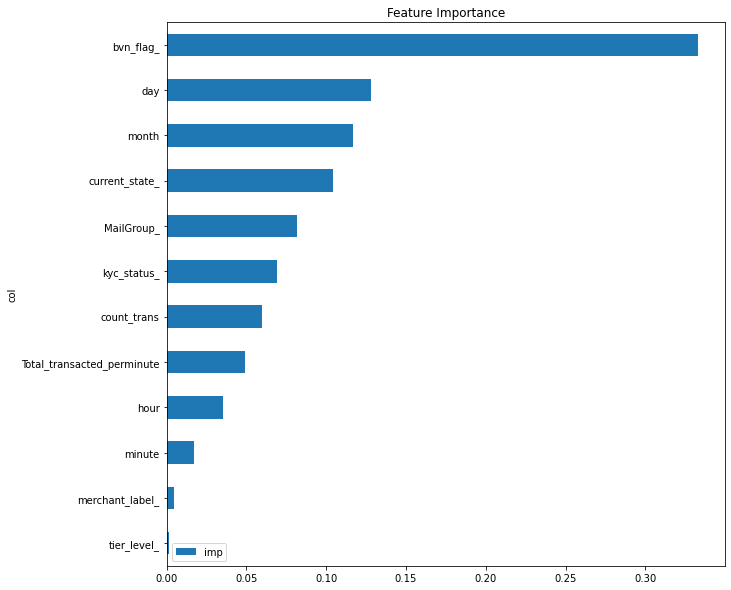

In [153]:
fea_imp = pd.DataFrame({'imp':rfc.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', title='Feature Importance',figsize=(10, 10))
plt.savefig('Random_Forest_Feature_importance.png')

## ROC AUC CURVE

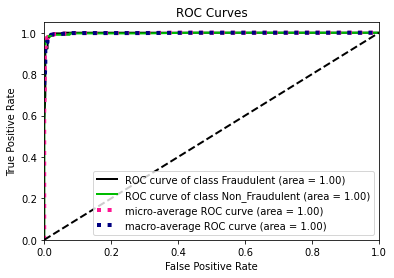

In [73]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test # ground truth labels
y_probas = probs # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

## Store model Artefact

In [154]:
import pickle
pickle.dump(rfc,open (f'en_freq_model_new_dec.pkl','wb'))
freq_model=pickle.load(open ('en_freq_model_new_dec.pkl','rb'))

## Out of Sample Validation

In [ ]:
Val = data.groupby('Fraud_Flag').apply(lambda x: x.sample(n=30)).reset_index(drop = True)
Val_data=Val[['source_wallet_guid','MailGroup','kyc_status', 'bvn_flag', 'date','MailGroup_','kyc_status_', 'bvn_flag_',  'month', 'day', 'hour', 'minute','count_trans','Fraud_Flag']].copy()
Val_data.to_csv('enaira_frequency_validation_new.csv',index=False)

In [ ]:
def make_predictions(df):
    ##load model
    freq_model=pickle.load(open ('en_freq_model_new.pkl','rb'))
    ##load label encoder
    file = open("enc.obj",'rb')
    enc_loaded = pickle.load(file)
    
    df_p=df[['MailGroup', 'kyc_status', 'bvn_flag','month', 'day', 'hour',
       'minute', 'count_trans']]
    
    df_p[['MailGroup_', 'kyc_status_', 'bvn_flag_']]=df_p[['MailGroup', 'kyc_status', 'bvn_flag']]
    
    df_u=df_p[['MailGroup_', 'kyc_status_', 'bvn_flag_','month', 'day', 'hour',
       'minute', 'count_trans']]
    
    col=['MailGroup_', 'kyc_status_', 'bvn_flag_']
    
    df_u[col]= enc_loaded.transform(df_u[col])
    
    predss= freq_model.predict(df_u)
    
    final_pred= pd.DataFrame({'source_wallet_guid':  df.source_wallet_guid,
                               'date': df.date,
                               'bvn_flag':df.bvn_flag,
                               'MailGroup':df.MailGroup,
                               'kyc_status':df.kyc_status,  
                               'count_trans':df.count_trans,
                               'day':df.day,
                               'month':df.month,
                               'hour':df.hour,
                               'minute':df.minute,
                               'Prediction':predss})
    
    th_props = [
      ('font-size', '18px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', '#6d6d6d'),
      ('background-color', '#f7ffff')
      ]

    td_props = [
      ('font-size', '15px')
      ]

    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]
    
    final_pred =final_pred[final_pred['Prediction']=='Fraudulent']
    final_pred=final_pred[['source_wallet_guid', 'date',
      'day', 'hour', 'minute', 'count_trans', 'Prediction']]
    final_pred=final_pred.style.set_properties(**{'text-align': 'center'}).set_table_styles(styles)
    final_pred.set_properties(subset=['Prediction'],**{'background-color': 'red'})
    return final_pred 



In [ ]:
def send_email(user,pwd,subject):
    df_s=make_predictions(Val_data)
    #df_s.set_properties(**{'background-color': 'red'}, subset=['Prediction'])
    try:
        df_html=df_s.hide_index().render()
        
        recipients=["foyelami@bluechiptech.biz"]
                # "ODosunmu@renmoney.com",
                #"DOkwechime@renmoney.com"
                # "RMM_ALL@renmoney.com"
                #FOyelami@renmoney.com
        
        msg =MIMEMultipart('alternative')
        
        msg['Subject']=subject
        msg['From']=user
        msg['To']=",".join(recipients)
                
        html= """\
        <html>
            <head>
            </head>
              <link rel='stylesheet' href='http://maxcdn.bootstrapcdn.com/bootstrap/3.3.6/css/bootstrap.min.css'>
               <body>
                   <p>
                   <br>Hello Ops Team</br>
                 
                    <br>
                   The following users have been flagged for making suspicious transactions: please look into this
                   </br>
                   </br>
                   
                   </br> 
                   </p>
               </body>
        </html>
        """
        #html = "df_html".join((df_html,message_style))
        html += df_html
        part2 = MIMEText(html.encode('utf-8'),'html','utf-8')
        
        #msg.attach(dfPart2)
        msg.attach(part2)
        print(df_html)
       
        
        server=smtplib.SMTP("smtp.office365.com",587)
        server.starttls()
        server.login(user,pwd)
        
        server.sendmail(user, recipients, msg.as_string())
        server.close()
        
        print("Mail Sent!")
        
    except Exception as e:
        print(str(e))
        print("Failed to send mail")


In [ ]:
def main():
    send_email("foyelami@bluechiptech.biz","Goldfinch22","DataOps: Anonamly Detection System  !!!")
    print('email sent successfully')
if __name__ == '__main__':main()